# Simple AutoEncoder for MNIST

This notebook is adapted from: https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder

In this notebook, I try to train a simple CNN-based auto-encoder. Besides, I also demo how to use learning rate finder pacakge from [davidtvs/pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder)

In [ ]:
!pip install tqdm
!pip install ipdb
!pip install torch-lr-finder

In [1]:
import os

import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

In [2]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    torchvision.transforms.Lambda(lambda img: img.view(img.size(0), -1))
])

batch_size = 128
dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128), 
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Tanh() # -1 ~ 1
        )

    def forward(self, x):
        x_ = self.encoder(x)
        out = self.decoder(x_)
        return out, x_

In [4]:
class LossRecorder:
    def __init__(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)
        plt.ion()
        
    def update(self, X, Y):
        self.fig.show()
        self.ax.clear()
        self.ax.set_xlabel('epoch')
        self.ax.set_ylabel('loss')
        self.ax.plot(X, Y)
        self.fig.canvas.draw()

In [5]:
import ipdb
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def train(model, criterion, optimizer, train_dataloader,
          loss_recorder=None,
          avg_loss_list=None,
          epochs=10):
    
    if avg_loss_list is None:
        avg_loss_list = []
        
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        
        for idx, data in enumerate(dataloader, start=1):
            img, _ = data
            img = img.to('cuda')
          
            output, _ = model(img)
            loss = criterion(output, img)
            epoch_loss += loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            num_batches = idx
            
        avg_epoch_loss = float((epoch_loss / num_batches).data.cpu())
        avg_loss_list.append(avg_epoch_loss)
        
        # Display Loss
        if loss_recorder is not None:
            loss_recorder.update(list(range(len(avg_loss_list))), avg_loss_list)
                   
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, epochs, avg_epoch_loss))
        if epoch % 10 == 0:
            pic = to_img(output.cpu().data)
            save_image(pic, './mlp_img/image_{}.png'.format(epoch))
        
    return avg_loss_list

## Use learning rate finder to find the appropriate learning rate

In [6]:
from torch_lr_finder import TrainDataLoaderIter


class AutoEncoderForLrFinder(nn.Module):
    def __init__(self, model):
        super(AutoEncoderForLrFinder, self).__init__()
        self.model = model
        
    def forward(self, x):
        out, x_ = self.model(x)
        return out
    
"""
ref. https://github.com/davidtvs/pytorch-lr-finder/blob/master/examples/lrfinder_cifar10_dataloader_iter.ipynb
"""
class CustomIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data[0], batch_data[0]

custom_dataloader = CustomIter(dataloader)
model = AutoEncoder().cuda()
model_ = AutoEncoderForLrFinder(model)

# Verify the implementation of CustomIter
for inputs, labels in custom_dataloader:
    print(inputs.shape, labels.shape)
    print()
    break

torch.Size([128, 1, 784]) torch.Size([128, 1, 784])




Learning rate search finished. See the graph with {finder_name}.plot()


<IPython.core.display.Javascript object>


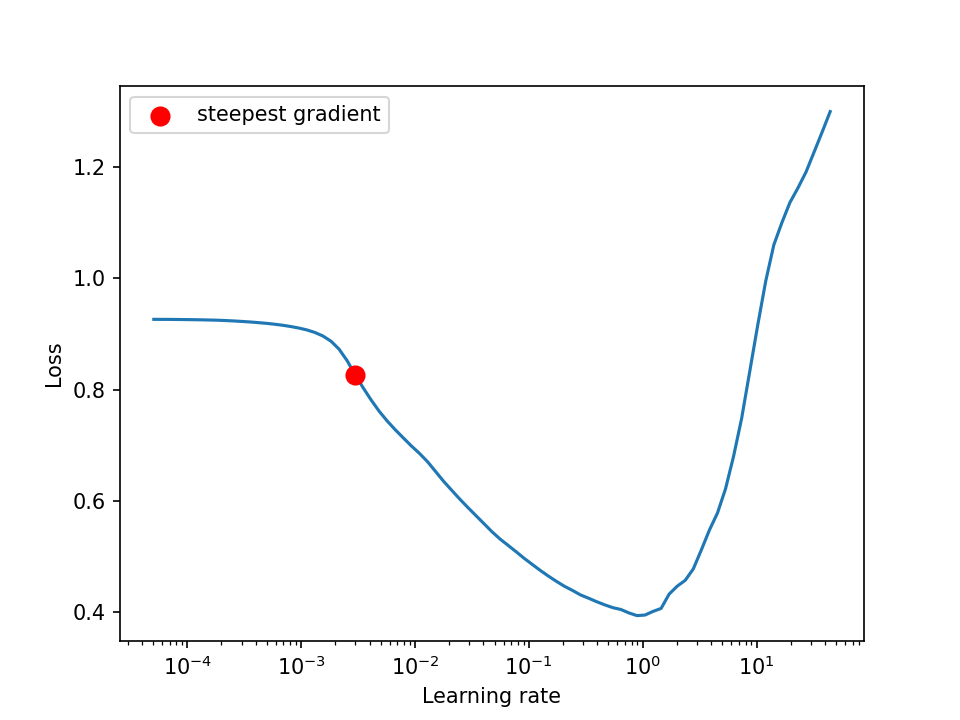

LR suggestion: steepest gradient
Suggested LR: 2.98E-03


In [7]:
from torch_lr_finder import LRFinder

learning_rate = 1e-5
weight_decay = 1e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

lr_finder = LRFinder(model_, optimizer, criterion, device="cuda")
lr_finder.range_test(custom_dataloader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

<IPython.core.display.Javascript object>


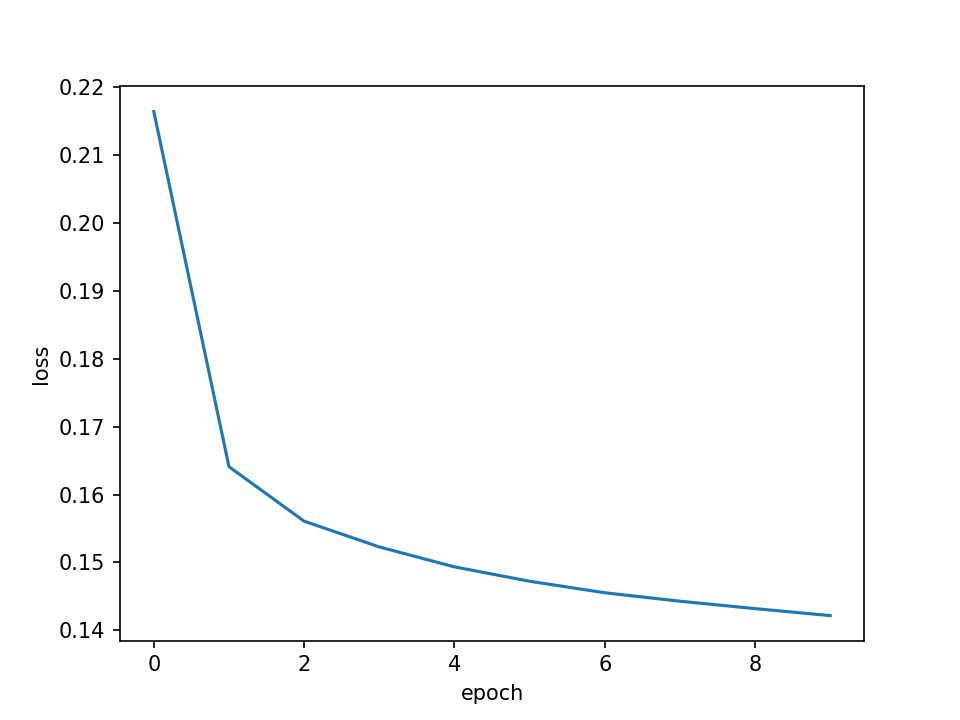

In [8]:
learning_rate = 2.98E-03

model = AutoEncoder().cuda()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)
loss_recorder = LossRecorder()

## Training

In [9]:
num_epochs = 10

train(model=model,
      criterion=criterion,
      optimizer=optimizer,
      train_dataloader=dataloader,
      loss_recorder=loss_recorder,
      epochs=num_epochs)

epoch [1/10], loss:0.2164
epoch [2/10], loss:0.1641
epoch [3/10], loss:0.1561
epoch [4/10], loss:0.1523
epoch [5/10], loss:0.1494
epoch [6/10], loss:0.1472
epoch [7/10], loss:0.1455
epoch [8/10], loss:0.1443
epoch [9/10], loss:0.1432
epoch [10/10], loss:0.1422


[0.21637989580631256,
 0.16409844160079956,
 0.15607941150665283,
 0.15228502452373505,
 0.14935404062271118,
 0.1472344994544983,
 0.14553938806056976,
 0.1442975103855133,
 0.14320506155490875,
 0.14217714965343475]

## Results

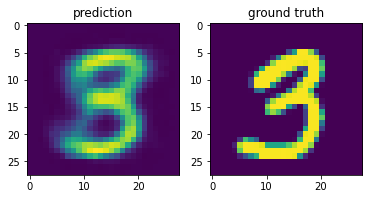

In [12]:
from matplotlib.pyplot import imshow
%matplotlib inline
import numpy as np


with torch.no_grad():
    for inputs, labels in dataloader:
        x = inputs.to('cuda')
        outputs, x_ = model(x)
        outputs = outputs.to('cpu')
        original = to_img(inputs[0])
        original.squeeze_(0).numpy()
        original = np.transpose(original, (1, 2, 0))
        
        result = to_img(outputs[0])
        result = result.squeeze(0).numpy()
        result = np.transpose(result, (1, 2, 0))
        break

plt.subplot(121)
plt.title('prediction')
imshow(result)
plt.subplot(122)
plt.title('ground truth')
imshow(original)

In [ ]:
torch.save(model.state_dict(), './sim_autoencoder.pth')